# Exploration and concatenation of RTE eCO2mix data

Explore the structure of RTE data:

1. Installed wind and solar power (`parc-national-annuel-prod-eolien-solaire.csv`)
2. Production data, at 30 min timestep

Export a self-contained file for analysis of the complementarity of solar and wind production [REn_Complementarity.ipynb](./REn_Complementarity.ipynb)

PH, march 2019

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset 1: Installed solar & wind power

In [2]:
df = pd.read_csv('parc-national-annuel-prod-eolien-solaire.csv', sep=';', index_col=0)
df.index.name = None
df.rename(columns={'Parc installé éolien (MW)':'P_wind', 'Parc installé solaire (MW)': 'P_sol'}, inplace=True)
df.sort_index(inplace=True)
df.head(3)

,P_wind,P_sol
2001,94.0,0.0
2002,129.0,0.0
2003,219.0,0.0


convert index to dates (2001 into date 2001-12-31).
* date parsing not good because it generates 2001-01-01
* easier to regenerate the index from scratch

In [3]:
df.index = pd.date_range(str(df.index[0]),periods=len(df), freq='Y')
df.tail(3)

,P_wind,P_sol
2016-12-31,11761.0,6773.0
2017-12-31,13550.0,7654.0
2018-12-31,15108.0,8527.0


In [4]:
df.index

DatetimeIndex(['2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31',
               '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31',
               '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31',
               '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31',
               '2017-12-31', '2018-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

Plot. (NB, plot anchoring using the DataFrame plot method is wrong)

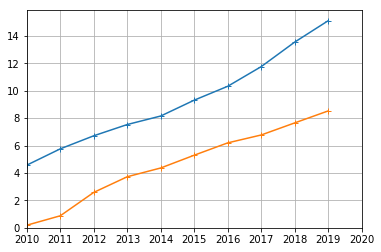

In [5]:
plt.plot(df.index, df/1e3, '-+')

plt.grid()
plt.xlim('2010','2020')
plt.ylim(ymin=0);

### Hourly interpolation

In [ ]:
inspow = df['2012':].resample('30T').interpolate()

In [25]:
inspow.head(3)

,P_wind,P_sol
2012-12-31 00:00:00,7536.000000,3727.000000
2012-12-31 00:30:00,7536.035445,3727.036473
2012-12-31 01:00:00,7536.070890,3727.072945


NB : last index is `2018-12-31 00:00:00`, and not `2018-12-31 23:30:00` as we may whish

In [26]:
inspow.tail(3)

,P_wind,P_sol
2018-12-30 23:00:00,15107.822146,8526.900342
2018-12-30 23:30:00,15107.911073,8526.950171
2018-12-31 00:00:00,15108.000000,8527.000000


Fix the last day of 2018

In [79]:
last_day = pd.date_range('2018-12-31 00:30','2018-12-31 23:30',freq='30T')
last_day
last_day = pd.DataFrame(index=last_day)
last_day.tail(3)

""
2018-12-31 22:30:00
2018-12-31 23:00:00
2018-12-31 23:30:00


In [82]:
inspow = pd.concat([inspow, last_day], sort=False)
inspow.tail(3)

,P_wind,P_sol
2018-12-31 21:30:00,NaN,NaN
2018-12-31 22:00:00,NaN,NaN
2018-12-31 22:30:00,NaN,NaN
2018-12-31 23:00:00,NaN,NaN
2018-12-31 23:30:00,NaN,NaN


In [84]:
inspow = inspow.ffill()
inspow.tail(3)

,P_wind,P_sol
2018-12-31 21:30:00,15108.0,8527.0
2018-12-31 22:00:00,15108.0,8527.0
2018-12-31 22:30:00,15108.0,8527.0
2018-12-31 23:00:00,15108.0,8527.0
2018-12-31 23:30:00,15108.0,8527.0


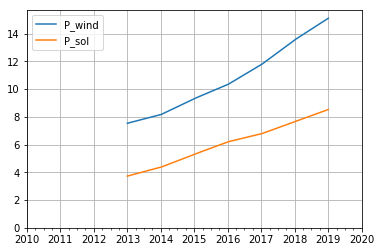

In [85]:
(inspow/1e3).plot()
plt.grid()
plt.xlim('2010','2020')
plt.ylim(ymin=0);

## Dataset 2: Production data

In [34]:
df = pd.read_csv('eCO2mix_RTE_Annuel-Definitif_2015.xls.xz', compression='xz', encoding='windows-1252',
                 sep='\t', skipfooter=2,engine='python',
                 index_col=False, parse_dates={'date':[2,3]})

In [35]:
df.head()

,date,Périmètre,Nature,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,...,Gaz - TAC,Gaz - Cogén.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz
0,2015-01-01 00:00:00,France,Données définitives,74494.0,72900,73700,269.0,2487.0,3476.0,57982.0,...,3.0,2056.0,1350.0,66.0,4810.0,3093.0,1418.0,560.0,181.0,197.0
1,2015-01-01 00:15:00,France,Données définitives,NaN,72250,73050,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 00:30:00,France,Données définitives,73481.0,71600,72400,319.0,2087.0,2691.0,57856.0,...,9.0,1926.0,670.0,86.0,4616.0,3561.0,1487.0,507.0,180.0,210.0
3,2015-01-01 00:45:00,France,Données définitives,NaN,70750,71500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 01:00:00,France,Données définitives,71506.0,69900,70600,320.0,1716.0,2436.0,57787.0,...,9.0,1919.0,422.0,86.0,4492.0,2805.0,1182.0,508.0,174.0,212.0


keep only data every 30 minutes

In [36]:
df = df.iloc[::2,:]
df.head()

,date,Périmètre,Nature,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,...,Gaz - TAC,Gaz - Cogén.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz
0,2015-01-01 00:00:00,France,Données définitives,74494.0,72900,73700,269.0,2487.0,3476.0,57982.0,...,3.0,2056.0,1350.0,66.0,4810.0,3093.0,1418.0,560.0,181.0,197.0
2,2015-01-01 00:30:00,France,Données définitives,73481.0,71600,72400,319.0,2087.0,2691.0,57856.0,...,9.0,1926.0,670.0,86.0,4616.0,3561.0,1487.0,507.0,180.0,210.0
4,2015-01-01 01:00:00,France,Données définitives,71506.0,69900,70600,320.0,1716.0,2436.0,57787.0,...,9.0,1919.0,422.0,86.0,4492.0,2805.0,1182.0,508.0,174.0,212.0
6,2015-01-01 01:30:00,France,Données définitives,71505.0,70600,71300,320.0,1589.0,2440.0,58156.0,...,10.0,1924.0,420.0,86.0,4369.0,2623.0,1301.0,512.0,180.0,212.0
8,2015-01-01 02:00:00,France,Données définitives,71134.0,70500,71100,320.0,1490.0,2441.0,57974.0,...,9.0,1927.0,419.0,86.0,4318.0,2670.0,1115.0,509.0,182.0,211.0


In [37]:
df.set_index('date', verify_integrity=True, inplace=True)
df.index.name = ''
df.head()

,Périmètre,Nature,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,Eolien,...,Gaz - TAC,Gaz - Cogén.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz
,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,France,Données définitives,74494.0,72900,73700,269.0,2487.0,3476.0,57982.0,1268.0,...,3.0,2056.0,1350.0,66.0,4810.0,3093.0,1418.0,560.0,181.0,197.0
2015-01-01 00:30:00,France,Données définitives,73481.0,71600,72400,319.0,2087.0,2691.0,57856.0,1343.0,...,9.0,1926.0,670.0,86.0,4616.0,3561.0,1487.0,507.0,180.0,210.0
2015-01-01 01:00:00,France,Données définitives,71506.0,69900,70600,320.0,1716.0,2436.0,57787.0,1356.0,...,9.0,1919.0,422.0,86.0,4492.0,2805.0,1182.0,508.0,174.0,212.0
2015-01-01 01:30:00,France,Données définitives,71505.0,70600,71300,320.0,1589.0,2440.0,58156.0,1412.0,...,10.0,1924.0,420.0,86.0,4369.0,2623.0,1301.0,512.0,180.0,212.0
2015-01-01 02:00:00,France,Données définitives,71134.0,70500,71100,320.0,1490.0,2441.0,57974.0,1447.0,...,9.0,1927.0,419.0,86.0,4318.0,2670.0,1115.0,509.0,182.0,211.0


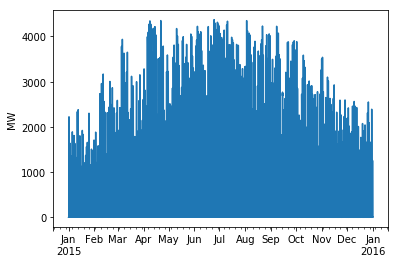

In [39]:
df.Solaire.plot()
plt.ylabel('MW');

### File reading automation

In [46]:
def read_eCO2mix(fname):
    """read eCO2mix data file. keep only wind, sun and load"""
    df = pd.read_csv(fname, compression='xz', encoding='windows-1252',
                 sep='\t', skipfooter=2,engine='python',
                 index_col=False, parse_dates={'date':[2,3]})
    # keep only data at 30 min step
    df = df.iloc[::2,:]
    # set date as the index
    df.set_index('date', verify_integrity=True, inplace=True)
    df.index.name = ''
    return df.loc[:,['Consommation','Eolien','Solaire']]

In [47]:
df = read_eCO2mix('eCO2mix_RTE_Annuel-Definitif_2015.xls.xz')

### Data concatenation

2015 - 2018

In [64]:
!ls eCO2mix*.xz

eCO2mix_RTE_Annuel-Definitif_2015.xls.xz
eCO2mix_RTE_Annuel-Definitif_2016.xls.xz
eCO2mix_RTE_Annuel-Definitif_2017.xls.xz
eCO2mix_RTE_En-cours-Consolide.xls.xz


In [ ]:
fname_list = [
    'eCO2mix_RTE_Annuel-Definitif_2015.xls.xz',
    'eCO2mix_RTE_Annuel-Definitif_2016.xls.xz',
    'eCO2mix_RTE_Annuel-Definitif_2017.xls.xz',
    'eCO2mix_RTE_En-cours-Consolide.xls.xz'
]

In [56]:
fname = fname_list[0]
print(f'reading {fname}...')
df = read_eCO2mix(fname)

for fname in fname_list[1:]:
    print(f'reading {fname}...')
    df =  pd.concat([df, read_eCO2mix(fname)])

reading eCO2mix_RTE_Annuel-Definitif_2015.xls.xz...
reading eCO2mix_RTE_Annuel-Definitif_2016.xls.xz...
reading eCO2mix_RTE_Annuel-Definitif_2017.xls.xz...
reading eCO2mix_RTE_En-cours-Consolide.xls.xz...


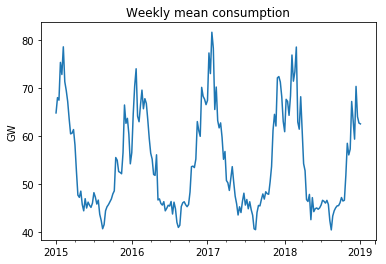

In [63]:
(df/1e3).resample('1W').mean().Consommation.plot()
plt.title('Weekly mean consumption')
plt.ylabel('GW');

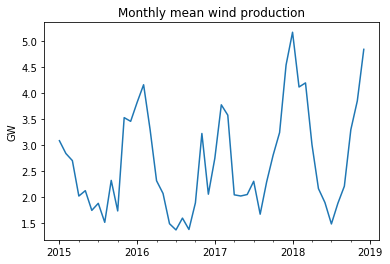

In [143]:
(df/1e3).resample('1M').mean().Eolien.plot()
plt.title('Monthly mean wind production')
plt.ylabel('GW');

In [69]:
df.Eolien.tail()


2018-12-31 21:30:00    1416.0
2018-12-31 22:00:00    1460.0
2018-12-31 22:30:00    1551.0
2018-12-31 23:00:00    1533.0
2018-12-31 23:30:00    1535.0
Name: Eolien, dtype: float64

### Compute capacity factor at each instant

In [88]:
wind_cf = (df.Eolien/inspow.P_wind).dropna()
solar_cf = (df.Solaire/inspow.P_sol).dropna()

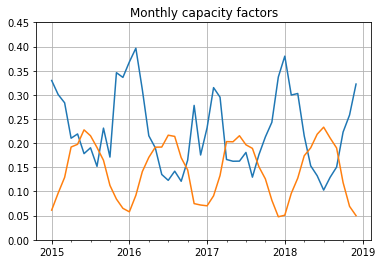

In [144]:
wind_cf.resample('1M').mean().plot()
solar_cf.resample('1M').mean().plot()
plt.ylim(0,0.45)
plt.title('Monthly capacity factors')
plt.grid()

Comparaison avec RTE's [Panorama de l’électricité renouvelable](https://www.rte-france.com/fr/article/panorama-de-l-electricite-renouvelable), December 2018.

→ coherent

![Production éolienne (GWh) et facteur de charge mensuels (%), Panorama de l’Électricité Renouvelable en 2018 p16](wind_cf.png)
![Production solaire (GWh) et facteur de charge (%) mensuels, Panorama de l’Électricité Renouvelable en 2018, p24](solar_cf.png)

## Export load/wind cf/solar cf

In [97]:
lws = pd.DataFrame({'load': df.Consommation, 'wind_cf': wind_cf, 'solar_cf': solar_cf})
lws.head(3)

,load,wind_cf,solar_cf
2015-01-01 00:00:00,74494.0,0.136113,0.000000
2015-01-01 00:30:00,73481.0,0.144163,-0.000189
2015-01-01 01:00:00,71506.0,0.145558,-0.000189


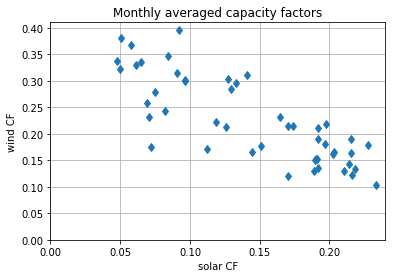

In [129]:
plt.plot(lws.resample('1M').mean().solar_cf, lws.resample('1M').mean().wind_cf, 'd')
ax = plt.gca()
ax.grid(True)
ax.set(
    title='Monthly averaged capacity factors',
    xlim=(0, 0.24),
    xlabel='solar CF',
    ylim=(0, 0.41),
    ylabel='wind CF'
);

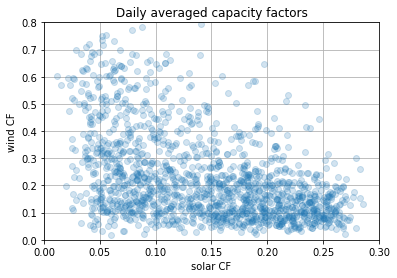

In [141]:
plt.plot(lws.resample('1D').mean().solar_cf, lws.resample('1D').mean().wind_cf, 'o', alpha=0.2)
ax = plt.gca()
ax.grid(True)
ax.set(
    title='Daily averaged capacity factors',
    xlim=(0, 0.3),
    xlabel='solar CF',
    ylim=(0, 0.8),
    ylabel='wind CF'
);

In [106]:
lws.round(6).to_csv('load_wind_solar.csv')

In [107]:
!head load_wind_solar.csv

,load,wind_cf,solar_cf
2015-01-01 00:00:00,74494.0,0.136113,0.0
2015-01-01 00:30:00,73481.0,0.144163,-0.000189
2015-01-01 01:00:00,71506.0,0.145558,-0.000189
2015-01-01 01:30:00,71505.0,0.151568,-0.000189
2015-01-01 02:00:00,71134.0,0.155324,-0.000189
2015-01-01 02:30:00,70856.0,0.161764,0.0
2015-01-01 03:00:00,68840.0,0.164554,0.0
2015-01-01 03:30:00,67315.0,0.168524,0.0
2015-01-01 04:00:00,65749.0,0.168416,0.0


In [118]:
!ls -hl load_wind_solar.csv

-rw-r--r-- 1 pierre pierre 3,1M mars   4 15:23 load_wind_solar.csv


CSV file compression: 3.1 MB to 0.6 MB

In [120]:
!xz load_wind_solar.csv

In [121]:
!ls -hl load_wind_solar.csv.xz

-rw-r--r-- 1 pierre pierre 558K mars   4 15:23 load_wind_solar.csv.xz
